We'll create a model that predicts crop yields for apples and oranges (target variables) by looking at the average temperature, rainfall and humidity (input variables or features) in a region


In a linear regression model, each target variable is estimated to be a weighted sum of the input variables, offset by some constant, known as a bias :

**yield_apple  = w11 * temp + w12 * rainfall + w13 * humidity + b1**

**yield_orange = w21 * temp + w22 * rainfall + w23 * humidity + b2**

Visually, it means that the yield of apples is a linear or planar function of temperature, rainfall and humidity

![Data](https://i.imgur.com/6Ujttb4.png)

In [1]:
import torch
import numpy as np

**Training data**

The training data can be represented using 2 matrices: inputs and targets, each with one row per observation, and one column per variable.

In [2]:
# Input (temp, rainfall, humidity)
inputs = np.array([
    [73,67,43],
    [91,88,64],
    [87,134,58],
    [102,43,37],
    [69,96,70]],dtype='float32')

In [3]:
# Targets (apples, oranges)
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119]], dtype='float32')

#### Convert inputs and targets to tensors

In [4]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

print(inputs)
print(targets)

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


**Linear regression model from scratch**

The weights and biases (w11, w12,... w23, b1 & b2) can also be represented as matrices, initialized as random values. The first row of w and the first element of b are used to predict the first target variable i.e. yield of apples, and similarly the second for oranges.

**yield_apple  = w11 * temp + w12 * rainfall + w13 * humidity + b1**

**yield_orange = w21 * temp + w22 * rainfall + w23 * humidity + b2**

In [5]:
# Weights and Bias

w = torch.randn(2,3,requires_grad = True)
b = torch.randn(2,requires_grad = True)
print(w)
print(b)

tensor([[ 0.4242,  1.2748, -0.4466],
        [ 1.1766, -1.0144,  0.4061]], requires_grad=True)
tensor([-0.4679,  1.5108], requires_grad=True)


```torch.randn``` creates a tensor with the given shape, with elements picked randomly from a normal distribution with mean 0 and standard deviation 1.

![Model](https://i.imgur.com/WGXLFvA.png)

In [6]:
def model(x):
    return x@w.t() + b

```@``` represents matrix multiplication in PyTorch, and the ```.t``` method returns the transpose of a tensor.

The matrix obtained by passing the input data into the model is a set of predictions for the target variables.

**Generate Prediction**

In [7]:
preds = model(inputs)
print(preds)

tensor([[ 96.7125,  36.8982],
        [121.7422,  45.3025],
        [181.3674,  -8.5027],
        [ 81.0988,  92.9271],
        [119.9281,  13.7399]], grad_fn=<AddBackward0>)


You can see that there's a huge difference between the predictions of our model, and the actual values of the target variables. Obviously, this is because we've initialized our model with random weights and biases, and we can't expect it to just work.

## Loss Function

Before we improve our model, we need a way to evaluate how well our model is performing. We can compare the model's predictions with the actual targets, using the following method:

1.Calculate the difference between the two matrices (preds and targets).

2.Square all elements of the difference matrix to remove negative values.

3.Calculate the average of the elements in the resulting matrix.

The result is a single number, known as the mean squared error (MSE).

In [8]:
# MSE
def mse(t1,t2):
    diff = t1-t2
    return torch.sum(diff*diff)/diff.numel()

```torch.sum``` returns the sum of all the elements in a tensor, and the ```.numel``` method returns the number of elements in a tensor. Let's compute the mean squared error for the current predictions of our model.

In [10]:
loss = mse(preds,targets)
print(loss)
print(torch.sqrt(loss))

tensor(4941.4844, grad_fn=<DivBackward0>)
tensor(70.2957, grad_fn=<SqrtBackward>)


Here’s how we can interpret the result: On average, each element in the prediction differs from the actual target by about 70 (square root of the loss 4941). And that’s pretty bad, considering the numbers we are trying to predict are themselves in the range 50–200. Also, the result is called the loss, because it indicates how bad the model is at predicting the target variables. Lower the loss, better the model.

## Compute Gradients

With PyTorch, we can automatically compute the gradient or derivative of the loss w.r.t. to the weights and biases, because they have ```requires_grad``` set to ```True```.

In [11]:
loss.backward()

The gradients are stored in the ```.grad``` property of the respective tensors. Note that the derivative of the loss w.r.t. the weights matrix is itself a matrix, with the same dimensions.

In [12]:
print(w)
print(w.grad)

tensor([[ 0.4242,  1.2748, -0.4466],
        [ 1.1766, -1.0144,  0.4061]], requires_grad=True)
tensor([[ 3860.3279,  3767.3276,  2269.4148],
        [-4270.8037, -6756.1323, -3698.8149]])


The loss is a quadratic function of our weights and biases, and our objective is to find the set of weights where the loss is the lowest. If we plot a graph of the loss w.r.t any individual weight or bias element, it will look like the figure shown below. A key insight from calculus is that the gradient indicates the rate of change of the loss, or the slope of the loss function w.r.t. the weights and biases.

If a gradient element is positive:

* increasing the element's value slightly will increase the loss.
* decreasing the element's value slightly will decrease the loss

![positive](https://i.imgur.com/hFYoVgU.png)


If a gradient element is negative:

* increasing the element's value slightly will decrease the loss.
* decreasing the element's value slightly will increase the loss.
![negative](https://i.imgur.com/w3Wii7C.png)


The increase or decrease in loss by changing a weight element is proportional to the value of the gradient of the loss w.r.t. that element. This forms the basis for the optimization algorithm that we'll use to improve our model.


Before we proceed, we reset the gradients to zero by calling ```.zero_()``` method. We need to do this, because PyTorch accumulates, gradients i.e. the next time we call ```.backward``` on the loss, the new gradient values will get added to the existing gradient values, which may lead to unexpected results.

In [13]:
w.grad.zero_()
b.grad.zero_()
print(w.grad)
print(b.grad)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([0., 0.])


Adjust weights and biases using gradient descent

We'll reduce the loss and improve our model using the gradient descent optimization algorithm, which has the following steps:

1. Generate predictions

2. Calculate the loss

3. Compute gradients w.r.t the weights and biases

4. Adjust the weights by subtracting a small quantity proportional to the gradient

5. Reset the gradients to zero

In [14]:
preds = model(inputs)
preds

tensor([[ 96.7125,  36.8982],
        [121.7422,  45.3025],
        [181.3674,  -8.5027],
        [ 81.0988,  92.9271],
        [119.9281,  13.7399]], grad_fn=<AddBackward0>)

In [15]:
loss = mse(preds,targets)
print(loss)

tensor(4941.4844, grad_fn=<DivBackward0>)


In [16]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[ 3860.3279,  3767.3276,  2269.4148],
        [-4270.8037, -6756.1323, -3698.8149]])
tensor([ 43.9698, -55.9270])


### Adjust weights & reset gradients

In [18]:
with torch.no_grad():
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5
    w.grad.zero_()
    b.grad.zero_()

* We use ```torch.no_grad``` to indicate to PyTorch that we shouldn't track, calculate or modify gradients while updating the weights and biases.

* We multiply the gradients with a really small number (```10^-5``` in this case), to ensure that we don't modify the weights by a really large amount, since we only want to take a small step in the downhill direction of the gradient. This number is called the ***learning rate*** of the algorithm.

* After we have updated the weights, we reset the gradients back to zero, to avoid affecting any future computations.

In [19]:
print(w)
print(b)

tensor([[ 0.3470,  1.1995, -0.4920],
        [ 1.2620, -0.8793,  0.4801]], requires_grad=True)
tensor([-0.4688,  1.5120], requires_grad=True)


In [20]:
# Calculate loss
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

tensor(3097.7515, grad_fn=<DivBackward0>)


***Train for multiple epochs***


To reduce the loss further, we can repeat the process of adjusting the weights and biases using the gradients multiple times. Each iteration is called an epoch. Let's train the model for 100 epochs.

In [22]:
final_losses = []
for i in range(100):
    preds = model(inputs)
    loss = mse(preds,targets)
    final_losses.append(loss)
    print('For Epoch: {} Loss is {}'.format(i+1,loss))
    loss.backward()
    with torch.no_grad():
        w -= w.grad * 1e-5
        b -= b.grad * 1e-5
        w.grad.zero_()
        b.grad.zero_()

For Epoch: 1 Loss is 564.1050415039062
For Epoch: 2 Loss is 557.7675170898438
For Epoch: 3 Loss is 551.5086059570312
For Epoch: 4 Loss is 545.3272705078125
For Epoch: 5 Loss is 539.2225341796875
For Epoch: 6 Loss is 533.1935424804688
For Epoch: 7 Loss is 527.2391967773438
For Epoch: 8 Loss is 521.3585815429688
For Epoch: 9 Loss is 515.5508422851562
For Epoch: 10 Loss is 509.81494140625
For Epoch: 11 Loss is 504.1499938964844
For Epoch: 12 Loss is 498.55523681640625
For Epoch: 13 Loss is 493.0296936035156
For Epoch: 14 Loss is 487.57244873046875
For Epoch: 15 Loss is 482.1827697753906
For Epoch: 16 Loss is 476.85968017578125
For Epoch: 17 Loss is 471.6024475097656
For Epoch: 18 Loss is 466.41015625
For Epoch: 19 Loss is 461.28192138671875
For Epoch: 20 Loss is 456.21697998046875
For Epoch: 21 Loss is 451.21490478515625
For Epoch: 22 Loss is 446.2743225097656
For Epoch: 23 Loss is 441.394775390625
For Epoch: 24 Loss is 436.57550048828125
For Epoch: 25 Loss is 431.8157653808594
For Epoch:

In [23]:
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

tensor(198.4230, grad_fn=<DivBackward0>)


In [24]:
preds

tensor([[ 58.9359,  75.7584],
        [ 75.2683, 103.7539],
        [131.6254, 117.1893],
        [ 31.0121,  67.1637],
        [ 83.9614, 107.2058]], grad_fn=<AddBackward0>)

In [26]:
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])

Text(0.5, 0, 'Epoch')

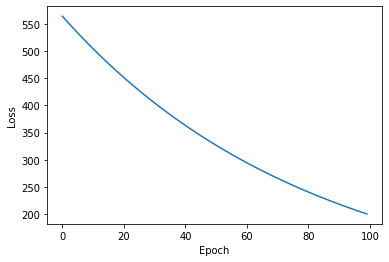

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(100),final_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Linear regression using PyTorch built-ins

In [29]:
import torch.nn as nn

In [30]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], [91, 88, 64], [87, 134, 58], 
                   [102, 43, 37], [69, 96, 70], [73, 67, 43], 
                   [91, 88, 64], [87, 134, 58], [102, 43, 37], 
                   [69, 96, 70], [73, 67, 43], [91, 88, 64], 
                   [87, 134, 58], [102, 43, 37], [69, 96, 70]], 
                  dtype='float32')

# Targets (apples, oranges)
targets = np.array([[56, 70], [81, 101], [119, 133], 
                    [22, 37], [103, 119], [56, 70], 
                    [81, 101], [119, 133], [22, 37], 
                    [103, 119], [56, 70], [81, 101], 
                    [119, 133], [22, 37], [103, 119]], 
                   dtype='float32')

inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

In [31]:
inputs

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.],
        [ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.],
        [ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])

**Dataset and DataLoader**

We'll create a TensorDataset, which allows access to rows from inputs and targets as tuples, and provides standard APIs for working with many different types of datasets in PyTorch.

In [32]:
from torch.utils.data import TensorDataset

In [33]:
train_ds = TensorDataset(inputs,targets)
train_ds[0:3]

(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.]]),
 tensor([[ 56.,  70.],
         [ 81., 101.],
         [119., 133.]]))

We'll also create a ```DataLoader```, which can split the data into batches of a predefined size while training. It also provides other utilities like shuffling and random sampling of the data.

In [34]:
from torch.utils.data import DataLoader

In [35]:
batch_size = 5
train_dl = DataLoader(train_ds,batch_size,shuffle=True)

In [36]:
for xb, yb in train_dl:
    print(xb)
    print(yb)
    break

tensor([[ 69.,  96.,  70.],
        [ 69.,  96.,  70.],
        [ 87., 134.,  58.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.]])
tensor([[103., 119.],
        [103., 119.],
        [119., 133.],
        [ 81., 101.],
        [119., 133.]])


**nn.Linear**

Instead of initializing the weights & biases manually, we can define the model using the nn.Linear class from PyTorch, which does it automatically.

In [38]:
model = nn.Linear(3,2)
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[-0.2774, -0.3018,  0.2094],
        [-0.0572, -0.4618, -0.4878]], requires_grad=True)
Parameter containing:
tensor([0.4542, 0.0034], requires_grad=True)


In [45]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.2774, -0.3018,  0.2094],
         [-0.0572, -0.4618, -0.4878]], requires_grad=True),
 Parameter containing:
 tensor([0.4542, 0.0034], requires_grad=True)]

In [39]:
preds = model(inputs)
preds

tensor([[-31.0118, -56.0909],
        [-37.9450, -77.0626],
        [-51.9768, -95.1515],
        [-33.0683, -43.7398],
        [-33.0007, -82.4250],
        [-31.0118, -56.0909],
        [-37.9450, -77.0626],
        [-51.9768, -95.1515],
        [-33.0683, -43.7398],
        [-33.0007, -82.4250],
        [-31.0118, -56.0909],
        [-37.9450, -77.0626],
        [-51.9768, -95.1515],
        [-33.0683, -43.7398],
        [-33.0007, -82.4250]], grad_fn=<AddmmBackward>)

In [40]:
import torch.nn.functional as F

In [41]:
loss_fn = F.mse_loss

In [46]:
opt = torch.optim.SGD(model.parameters(),lr=1e-5)

In [47]:
def fit(num_epochs, model, loss_fn, opt, train_dl):
    
    # Repeat for given number of epochs
    for epoch in range(num_epochs):
        
        # Train with batches of data
        for xb,yb in train_dl:
            
            # 1. Generate predictions
            pred = model(xb)
            
            # 2. Calculate loss
            loss = loss_fn(pred, yb)
            
            # 3. Compute gradients
            loss.backward()
            
            # 4. Update parameters using gradients
            opt.step()
            
            # 5. Reset the gradients to zero
            opt.zero_grad()
        
        # Print the progress
        if (epoch+1) % 10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

In [49]:
fit(100,model,loss_fn,opt,train_dl)

Epoch [10/100], Loss: 513.1780
Epoch [20/100], Loss: 511.0054
Epoch [30/100], Loss: 162.1580
Epoch [40/100], Loss: 275.6198
Epoch [50/100], Loss: 192.1761
Epoch [60/100], Loss: 120.6092
Epoch [70/100], Loss: 46.4603
Epoch [80/100], Loss: 77.1869
Epoch [90/100], Loss: 41.9344
Epoch [100/100], Loss: 50.8060


In [50]:
preds = model(inputs)
preds

tensor([[ 58.2916,  72.2051],
        [ 82.7025,  97.2687],
        [115.8335, 138.1595],
        [ 27.0973,  47.1482],
        [ 99.3563, 107.2716],
        [ 58.2916,  72.2051],
        [ 82.7025,  97.2687],
        [115.8335, 138.1595],
        [ 27.0973,  47.1482],
        [ 99.3563, 107.2716],
        [ 58.2916,  72.2051],
        [ 82.7025,  97.2687],
        [115.8335, 138.1595],
        [ 27.0973,  47.1482],
        [ 99.3563, 107.2716]], grad_fn=<AddmmBackward>)

In [51]:
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.],
        [ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.],
        [ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])